In [1]:
import cv2
import pandas as pd
import os
import shutil
import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
(width, height) = (128, 128)
batch_size = 64

In [3]:
df = pd.read_csv("annotations.csv")

In [4]:
df

filename  width  height                  class  xmin  ymin  \
0      maksssksksss0.png    512     366           without_mask    79   105   
1      maksssksksss0.png    512     366              with_mask   185   100   
2      maksssksksss0.png    512     366           without_mask   325    90   
3      maksssksksss1.png    400     156              with_mask   321    34   
4      maksssksksss1.png    400     156              with_mask   224    38   
...                  ...    ...     ...                    ...   ...   ...   
4067  maksssksksss98.png    400     267              with_mask   263    62   
4068  maksssksksss98.png    400     267              with_mask   344    80   
4069  maksssksksss99.png    400     267  mask_weared_incorrect   181    54   
4070  maksssksksss99.png    400     267              with_mask    99    87   
4071  maksssksksss99.png    400     267              with_mask   289    99   

      xmax  ymax  
0      109   142  
1      226   144  
2      360   141  
3      354    69  
4      261    73  
...    ...   ...  
4067   287    85  
4068   377   106  
4069   273   162  
4070   176   165  
4071   355   233  

[4072 rows x 8 columns]

In [5]:
def save_cropped_image(index, row):
    img = cv2.imread(f"./Kaggle-MaskDetection/images/{row['filename']}")
    crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
    resized_img = cv2.resize(crop_img, (width, height))
    if not os.path.exists(f"./Kaggle-MaskDetection/cropped/{row['class']}"):
        os.makedirs(f"./Kaggle-MaskDetection/cropped/{row['class']}")
    cv2.imwrite(f"./Kaggle-MaskDetection/cropped/{row['class']}/{index}-{row['filename']}", resized_img)

In [6]:
if os.path.exists('./Kaggle-MaskDetection/cropped'):
    shutil.rmtree('./Kaggle-MaskDetection/cropped')

if not os.path.exists('./Kaggle-MaskDetection/cropped'):
    os.makedirs('./Kaggle-MaskDetection/cropped')
    
for index, row in df.iterrows():
    save_cropped_image(index,row)

In [7]:
data_dir = f"./Kaggle-MaskDetection/cropped"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(width, height),
  batch_size=batch_size)


Found 4072 files belonging to 3 classes.
Using 3258 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(width, height),
  batch_size=batch_size)

Found 4072 files belonging to 3 classes.
Using 814 files for validation.


In [9]:
train_ds

<BatchDataset shapes: ((None, 128, 128, 3), (None,)), types: (tf.float32, tf.int32)>

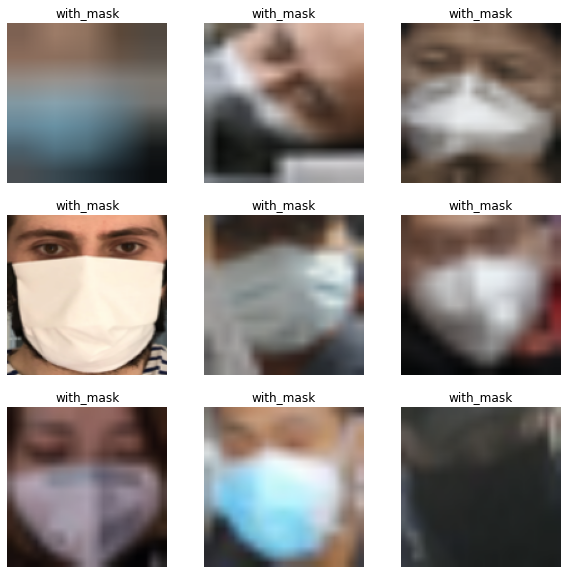

In [10]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 128, 128, 3)
(64,)


In [12]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalization_layer

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.027450982 0.9960785


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
num_classes = 3

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [18]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
51/51 [==============================] - 66s 1s/step - loss: 0.5621 - accuracy: 0.7592 - val_loss: 0.2724 - val_accuracy: 0.9042
Epoch 2/10
51/51 [==============================] - 83s 2s/step - loss: 0.2010 - accuracy: 0.9448 - val_loss: 0.2141 - val_accuracy: 0.9251
Epoch 3/10
51/51 [==============================] - 69s 1s/step - loss: 0.1663 - accuracy: 0.9477 - val_loss: 0.2607 - val_accuracy: 0.9165
Epoch 4/10
51/51 [==============================] - 74s 1s/step - loss: 0.1666 - accuracy: 0.9505 - val_loss: 0.2357 - val_accuracy: 0.9238
Epoch 5/10
51/51 [==============================] - 63s 1s/step - loss: 0.1587 - accuracy: 0.9497 - val_loss: 0.2565 - val_accuracy: 0.9201
Epoch 6/10
51/51 [==============================] - 64s 1s/step - loss: 0.1505 - accuracy: 0.9522 - val_loss: 0.2546 - val_accuracy: 0.9177
Epoch 7/10
51/51 [==============================] - 64s 1s/step - loss: 0.1397 - accuracy: 0.9543 - val_loss: 0.2008 - val_accuracy: 0.9361
Epoch 8/10
51/51 [==

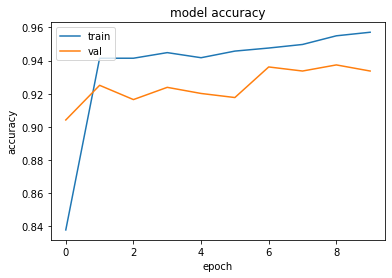

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

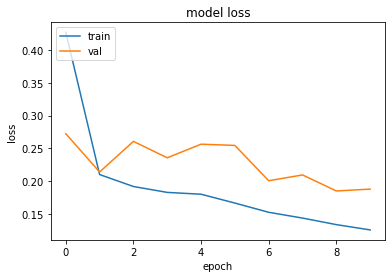

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()